In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from matplotlib import pyplot
import operator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import re
import sys
import pickle
from tqdm import tqdm
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFwlBB2YzTTdtjU7rLg4xngjbowZ47AVVaWZ3kzbUe52Kf6dsglkV4
Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/My Drive/train_cs.csv')
print(df1.columns)

Index(['UserID', 'YOB', 'Gender', 'Income', 'HouseholdStatus',
       'EducationLevel', 'Party', 'Happy', 'Q124742', 'Q124122',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059', 'Q98078',
       'Q98197', 'Q96024', 'votes'],
      dtype='object', length=110)


In [ ]:
df2 = pd.read_csv('/content/drive/My Drive/test_cs.csv')
print(df2.columns)

Index(['UserID', 'YOB', 'Gender', 'Income', 'HouseholdStatus',
       'EducationLevel', 'Party', 'Q124742', 'Q124122', 'Q123464',
       ...
       'Q99716', 'Q99581', 'Q99480', 'Q98869', 'Q98578', 'Q98059', 'Q98078',
       'Q98197', 'Q96024', 'votes'],
      dtype='object', length=109)


In [ ]:
print(df1.Happy.value_counts()) 
# frequency of distinct values under class lable in trainset

1    2604
0    2015
Name: Happy, dtype: int64


In [ ]:
# for analysis USerID is not required. So we can drop that
df1.drop(['UserID'], axis = 1, inplace = True)
df2.drop(['UserID'], axis = 1, inplace = True)

In [ ]:
print('train',len(df1))
print('test',len(df2))

train 4619
test 1980


In both train and test most of the field values are missing. There rare different ways to handle the missing values.
    1.Drop missing values/columns/rows
    2.Imputation

1.This is the simplest way to handle the missing values, but not the optimal way. If the dataset set is very large and very few of the observations are having missing fields then we can go with this option(this is in case of rows). In case of columns if more than 60% of the data is missing and if that feature is insignificant then we can eliminate the feature. But you may loose the potential information. So the better approach is imputation.

2.when compared to the previous approach this is slightly better one. In this we can deal with the data in different ways.
    a)Missing values can be replaced with any constant value like 0 or 1 or -1. Here in the given dataset almost all the features are categorical. if the feature is binary categorical then they can be replaced with 0 or 1 before applying machine learning model ans NAN values can be replaced with -1.
    b)Feature's NAN values can be replaced with mean,meadian or mode values of that particular column. 'Income' NAN values can be replaced with mean of the people's income in that age group.
    c)Any predicitve model(linear regression which can be applied on numerical feture) can be used to replace the missing values. Heatmap can also be used to find the correlation between the features. If 'Income' is highly correlated with 'YOB' and 'EducationLEvel' then these two can be used to fill the missing values of 'Income'.
    d)Multiple Imputation: it reduces uncertainty about missing values by calculating several different options. One of the most used method for imputaion is MICE.
    

In [ ]:
# convert both train and test 'YOB' to age
df1['YOB'] = 2014 - df1['YOB'] 
df2['YOB'] = 2014 - df2['YOB'] 

when giving dataset as input to ML algorithm, it should not contain any string
data. So data is to be encoded. In the given dataset, 'UserID' is the unique ID of each observation, except 'YOB','votes', remaining all are categorical.  Where as income and EducationLevel are ordinal. So while assigning indices to the feature categories order is to be considered.

Following is the code for that

In [ ]:
df1 = df1.replace({'HouseholdStatus': {'Married (w/kids)' :3, 'Single (no kids)':0, 'Married (no kids)':2,'Domestic Partners (no kids)':4,'Domestic Partners (w/kids)':5, 'Single (w/kids)':1}})
df2 = df2.replace({'HouseholdStatus': {'Married (w/kids)' :3, 'Single (no kids)':0, 'Married (no kids)':2,'Domestic Partners (no kids)':4,'Domestic Partners (w/kids)':5, 'Single (w/kids)':1}})

In [ ]:
df1 = df1.replace({'EducationLevel': {'Master\'s Degree':3, 'High School Diploma':0, 'Current K-12':1,'Current Undergraduate':2,'Bachelor\'s Degree':2, 'Associate\'s Degree':3,'Doctoral Degree':4}})
df2 = df2.replace({'EducationLevel': {'Master\'s Degree':3, 'High School Diploma':0, 'Current K-12':1,'Current Undergraduate':2,'Bachelor\'s Degree':2, 'Associate\'s Degree':3,'Doctoral Degree':4}})

In [ ]:
df1['Income'] = df1.Income.map({'$25,001 - $50,000':1,'over $150,000':5,'$75,000 - $100,000':3,'$50,000 - $74,999':2,'under $25,000':0,'$100,001 - $150,000':4})
df2['Income'] = df2.Income.map({'$25,001 - $50,000':1,'over $150,000':5,'$75,000 - $100,000':3,'$50,000 - $74,999':2,'under $25,000':0,'$100,001 - $150,000':4})

Income and EducationLevel are ordinal features.

In [ ]:
df1['Party'] = df1.Party.map({'Independent':0,'Democrat':1,'Republican':2,'Libertarian':3,'Other':4})
df2['Party'] = df2.Party.map({'Independent':0,'Democrat':1,'Republican':2,'Libertarian':3,'Other':4})

In [ ]:
df1['Gender'] = df1.Gender.map({'Male':0, 'Female':1})
df2['Gender'] = df2.Gender.map({'Male':0, 'Female':1})

In [ ]:
# take all the columns which are starting with 'Q'
filter_col = [col for col in df1 if col.startswith('Q')]
for col in filter_col: 
    # converted yes/no or other feature string values to binary 0 or 1
    #print(col) from the given pdf file possible answers for the questions have been collected
    d = {'No': 0, 'Yes': 1, 'Only-child':0, 'Check!':0,'Nope':1,'Optimist':1,'Pessimist':0,'Mom':0,'Dad':1,'Rent':0,'Own':1, 'Yay people!':0,'Grrr people':1,'Online':0,'In-person':1,'Yes!':1,'Umm...':0,'Socialize':1,'Space':0,'Cautious':1,'Risk-friendly':0,'Mac':1,'PC':0,'Supportive':1,'Demanding':0,'Tunes':0,'Talk':1,'People':0,'Technology':1,'TMI':0,'Mysterious':1,'Start':0,'End':1,'Circumstances':0,'Me':1,'A.M.':0,'P.M.':1,'Happy':0,'Right':1,'Hot headed':0,'Cool headed':1,'Standard hours':0,'Odd hours':1,'Idealist':0,'Pragmatist':1,'Giving':0,'Receiving':1,'Study first':0,'Try first':1,'Science':0,'Art':1,'Public':0,'Private':1}
    df1[col] = df1[col].map(d).fillna(df1[col])
    df2[col] = df2[col].map(d).fillna(df2[col])

In [ ]:
df1
# Finally dataset is having only numerical values and NAN .
#latter these NAN values can be either ignored or replaced with mean/neadian.mode or imputed
# base on the %of missing values

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,76.0,0.0,NaN,3.0,NaN,0.0,1,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,1.0,NaN,1.0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0.0,1.0,86
1,29.0,1.0,1.0,0.0,3.0,1.0,1,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,66
2,51.0,0.0,5.0,3.0,NaN,NaN,0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,101
3,17.0,0.0,3.0,0.0,0.0,2.0,1,NaN,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,98
4,18.0,0.0,2.0,0.0,1.0,NaN,1,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,NaN,NaN,NaN,NaN,NaN,NaN,1,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
4615,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20
4616,16.0,1.0,5.0,0.0,1.0,2.0,1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
4617,NaN,1.0,NaN,NaN,NaN,0.0,0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20


In [ ]:
df2

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,31.0,0.0,2.0,3.0,2.0,3.0,NaN,NaN,0.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,0.0,1.0,49
1,44.0,1.0,5.0,5.0,2.0,1.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,75
2,34.0,1.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,101
3,31.0,0.0,1.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,60
4,NaN,0.0,NaN,0.0,1.0,2.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,1.0,77
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
1977,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21
1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21


Outliers influence the existing data, and thus they should be handled before imputing missing values.

In [ ]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

# outliers are identified by inter quartile range. 
# in bith train and test, outliers are replaced with True
df1_TF = (df1 < (Q1 - 1.5 * IQR)) |(df1 > (Q3 + 1.5 * IQR))
print(df1_TF[df1_TF== True].count().sum())
df1_TF

df2_TF = (df2 < (Q1 - 1.5 * IQR)) |(df2 > (Q3 + 1.5 * IQR))
print(df2_TF[df2_TF== True].count().sum())
df2_TF

10164
4401


,EducationLevel,Gender,Happy,HouseholdStatus,Income,Party,Q100010,Q100562,Q100680,Q100689,Q101162,Q101163,Q101596,Q102089,Q102289,Q102674,Q102687,Q102906,Q103293,Q104996,Q105655,Q105840,Q106042,Q106272,Q106388,Q106389,Q106993,Q106997,Q107491,Q107869,Q108342,Q108343,Q108617,Q108754,Q108855,Q108856,Q108950,Q109244,Q109367,Q110740,...,Q117186,Q117193,Q118117,Q118232,Q118233,Q118237,Q118892,Q119334,Q119650,Q119851,Q120012,Q120014,Q120194,Q120379,Q120472,Q120650,Q120978,Q121011,Q121699,Q121700,Q122120,Q122769,Q122770,Q122771,Q123464,Q123621,Q124122,Q124742,Q96024,Q98059,Q98078,Q98197,Q98578,Q98869,Q99480,Q99581,Q99716,Q99982,YOB,votes
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
4,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1976,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

altogther there are 10155 outliers. there are two ways to deal with these outliers: first one is dropping and the second one is correcting. Dropping the outliers may lead to loss of information.So, outliers ar to be corrected. This can be done either by mean or mode.

In [ ]:
for i in (df1.columns):# to get rid of outliers
    median = df1[i].quantile(0.50) # each feature median is taken
    outlier = df1[i].quantile(0.95) #  95th % value
    outlier_10 = df1[i].quantile(0.10)# 10th % value
    df1[i] = np.where(df1[i] > outlier , outlier, df1[i])# replace value above 95% with median
    df1[i] = np.where(df1[i] < outlier_10, outlier_10,df1[i])# replace value below 10% with median

for i in (df2.columns):# to get rid of outliers
    median = df2[i].quantile(0.50) # each feature median is taken
    outlier = df2[i].quantile(0.95) #  95th % value
    outlier_10 = df2[i].quantile(0.10)# 10th % value
    df2[i] = np.where(df2[i] > outlier , outlier, df2[i])# replace value above 95% with median
    df2[i] = np.where(df2[i] < outlier_10, outlier_10,df2[i])# replace value below 10%

In [ ]:
df1

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,65.0,0.0,NaN,3.0,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,0.0,NaN,1.0,NaN,1.0,1.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,0.0,NaN,1.0,0.0,0.0,1.0,86.0
1,29.0,1.0,1.0,0.0,3.0,1.0,1.0,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,NaN,NaN,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,66.0
2,51.0,0.0,5.0,3.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,101.0
3,18.0,0.0,3.0,0.0,0.0,2.0,1.0,NaN,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,98.0
4,18.0,0.0,2.0,0.0,1.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4615,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4616,18.0,1.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8
4617,NaN,1.0,NaN,NaN,NaN,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,NaN,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.8


In [ ]:
df2

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,31.0,0.0,2.0,3.0,2.0,3.0,NaN,NaN,0.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,1.0,0.0,1.0,49.0
1,44.0,1.0,5.0,3.0,2.0,1.0,NaN,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,75.0
2,34.0,1.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,101.0
3,31.0,0.0,1.0,2.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,NaN,0.0,0.0,1.0,NaN,1.0,0.0,1.0,1.0,0.0,1.0,NaN,1.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,1.0,0.0,NaN,NaN,1.0,1.0,1.0,NaN,1.0,NaN,NaN,NaN,0.0,0.0,1.0,0.0,1.0,1.0,60.0
4,NaN,0.0,NaN,0.0,1.0,2.0,0.0,NaN,1.0,0.0,NaN,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,NaN,1.0,NaN,0.0,1.0,1.0,NaN,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,NaN,1.0,0.0,NaN,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,NaN,NaN,1.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,NaN,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
1976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
1977,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,NaN,1.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0
1978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0


In [ ]:
#features with missing values between 5-20% missing (mean/median is to be used to fill NAN values)
features_mean = []
for i in (df1.columns):
    if(df1[i].isnull().sum()*100/len(df1)) >=5 and (df1[i].isnull().sum()*100/len(df1))<=20:
        features_mean.append(i)
print(features_mean)

features_mean_test = []
for i in (df2.columns):
    if(df2[i].isnull().sum()*100/len(df2)) >=5 and (df2[i].isnull().sum()*100/len(df2))<=20:
        features_mean_test.append(i)
features_mean_test

['YOB', 'Gender', 'HouseholdStatus', 'Party']


['YOB', 'Gender', 'HouseholdStatus', 'Party']

In [ ]:
#sklearn SimpleImputer is used to fill the missing values. The featuers 'Gender', 
#'HouseholdStatus', 'Party' are categorical.so instead of mean/median considered 
#'most_frequent' strategy from SimpleImputer. As YOB' is a numerical feature so it is filled with mean value
from sklearn.impute import SimpleImputer

df_mean = df1[features_mean] # features with missing values between 5-20% missing
df_mean_test = df2[features_mean_test]

# age is replaced with mean
df_mean['YOB'].fillna(int(df_mean['YOB'].mean()), inplace=True)
df_mean_test['YOB'].fillna(int(df_mean_test['YOB'].mean()), inplace = True)


imp = SimpleImputer(strategy="most_frequent")
df_mean = imp.fit_transform(df1[features_mean])
df_mean_test = imp.transform(df2[features_mean_test])
for i in range(1,len(features_mean)):
    x = features_mean[i]
    df1[x] = df_mean[:,i].copy()
    
for i in range(1,len(features_mean_test)):
    x= features_mean_test[i]
    df2[x] = df_mean_test[:,i].copy()
    
    
df1['YOB'] = df_mean[:,0].copy()
df2['YOB'] = df_mean_test[:,0].copy()

In [ ]:
# KNN classifier has been used to predict the misclassified data
from sklearn.neighbors import KNeighborsClassifier
def impute_model_basic(df):
    # taken columns with null values into 'cols_nan'
    cols_nan = df.columns[df.isna().any()].tolist()    
    # taken columns with non null values into 'cols_no_nan'
    cols_no_nan = df.columns.difference(cols_nan).values    
    for col in cols_nan:
        test_data = df[df[col].isna()]# rows with null values are taken into testset
        train_data = df.dropna()#remaining into train
        #Kneighbors classifier is applied
        knr = KNeighborsClassifier(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
        #predict each test row with the trained model
        df.loc[df[col].isna(), col] = knr.predict(test_data[cols_no_nan])
        #updating columns with nan and without nan for updating train and test with new predicted rows
        cols_nan = df.columns[df.isna().any()].tolist()    
        cols_no_nan = df.columns.difference(cols_nan).values
    return df

In [ ]:
df_impu = impute_model_basic(df1)
df_impu

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Happy,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,65.0,0.0,2.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,86.0
1,29.0,1.0,1.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,66.0
2,51.0,0.0,5.0,3.0,2.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,101.0
3,18.0,0.0,3.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,98.0
4,18.0,0.0,2.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,98.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4614,18.0,0.0,0.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,26.8
4615,18.0,0.0,3.0,0.0,1.0,2.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,26.8
4616,18.0,1.0,5.0,0.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,26.8
4617,18.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,26.8


In [ ]:
X_testt = impute_model_basic(df2)# imputing the test data
X_testt

,YOB,Gender,Income,HouseholdStatus,EducationLevel,Party,Q124742,Q124122,Q123464,Q123621,Q122769,Q122770,Q122771,Q122120,Q121699,Q121700,Q120978,Q121011,Q120379,Q120650,Q120472,Q120194,Q120012,Q120014,Q119334,Q119851,Q119650,Q118892,Q118117,Q118232,Q118233,Q118237,Q117186,Q117193,Q116797,Q116881,Q116953,Q116601,Q116441,Q116448,...,Q108617,Q108856,Q108754,Q108342,Q108343,Q107869,Q107491,Q106993,Q106997,Q106272,Q106388,Q106389,Q106042,Q105840,Q105655,Q104996,Q103293,Q102906,Q102674,Q102687,Q102289,Q102089,Q101162,Q101163,Q101596,Q100689,Q100680,Q100562,Q99982,Q100010,Q99716,Q99581,Q99480,Q98869,Q98578,Q98059,Q98078,Q98197,Q96024,votes
0,31.0,0.0,2.0,3.0,2.0,3.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,49.0
1,44.0,1.0,5.0,3.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,75.0
2,34.0,1.0,2.0,0.0,3.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,101.0
3,31.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,60.0
4,18.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,77.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1975,18.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,28.0
1976,18.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,28.0
1977,18.0,0.0,2.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,28.0
1978,18.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,28.0


In [ ]:
from sklearn.preprocessing import LabelEncoder
df1_y = df_impu.Happy # separating the class label
df1_X = df_impu.drop(['Happy'],axis = 1) # taking remaining features

In [ ]:
scaler = StandardScaler()# standardising the data
X_train = scaler.fit_transform(df1_X) 
X_test = scaler.transform(X_testt)

X_train = pd.DataFrame(X_train)
X_train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107
0,2.234603,-0.745482,-0.153436,1.361152,-1.777974,-1.356886,-0.640610,-1.301870,-0.215507,-0.966988,-0.685285,0.784242,-0.375201,-0.749704,0.514237,-0.513901,-1.004557,-1.261181,-1.019899,0.0,-0.555426,1.520234,-0.750056,-1.402356,0.959886,1.378906,-0.467690,0.675750,1.020783,-0.890165,-0.508173,-0.723128,0.583767,-0.644310,1.751006,-0.929113,0.961136,0.381929,-0.63188,-0.721046,...,-0.313358,-0.538724,-0.575100,0.619151,-0.740568,1.043147,-3.043755,0.380439,-1.343314,0.793632,-0.547414,0.929113,1.248600,1.158061,-1.181943,1.108229,-1.049047,-0.601443,-0.714814,1.115532,-0.549752,0.587767,0.803448,-1.114067,1.427871,0.824030,-1.420205,-2.284007,1.041790,0.421919,-0.301547,-0.343308,0.476947,-2.194853,-0.757827,0.0,-0.911857,-0.775268,0.735319,0.491135
1,-0.226884,1.341415,-0.737227,-0.852637,1.362547,-0.456260,-0.640610,0.768126,-0.215507,1.034139,-0.685285,-1.275117,-0.375201,-0.749704,0.514237,1.945900,0.995464,-1.261181,0.980489,0.0,-0.555426,-0.657794,1.333233,0.713086,0.959886,-0.725213,-0.467690,0.675750,-0.979640,-0.890165,-0.508173,1.382880,0.583767,1.552049,1.751006,-0.929113,0.961136,0.381929,-0.63188,1.386873,...,-0.313358,-0.538724,1.738827,0.619151,1.350315,-0.958638,-3.043755,0.380439,0.744427,0.793632,-0.547414,0.929113,-0.800897,-0.863512,-1.181943,-0.902341,-1.049047,-0.601443,-0.714814,-0.896433,-0.549752,-1.701353,0.803448,-1.114067,-0.700343,-1.213548,0.704124,0.437827,-0.959886,0.421919,-0.301547,-0.343308,0.476947,0.455611,1.319563,0.0,1.096663,1.289877,0.735319,-0.226825
2,1.277358,-0.745482,1.597937,1.361152,0.315707,0.444366,-0.640610,0.768126,-0.215507,1.034139,-0.685285,-1.275117,2.665241,-0.749704,0.514237,-0.513901,-1.004557,-1.261181,0.980489,0.0,-0.555426,1.520234,1.333233,-1.402356,-1.041790,-0.725213,-0.467690,0.675750,-0.979640,1.123387,-0.508173,1.382880,0.583767,-0.644310,-0.571100,1.076295,0.961136,0.381929,-0.63188,1.386873,...,-0.313358,-0.538724,-0.575100,0.619151,1.350315,1.043147,0.328542,0.380439,-1.343314,0.793632,-0.547414,-1.076295,1.248600,1.158061,0.846064,1.108229,-1.049047,-0.601443,1.398966,1.115532,-0.549752,0.587767,0.803448,-1.114067,1.427871,0.824030,-1.420205,0.437827,-0.959886,0.421919,-0.301547,2.912834,0.476947,0.455611,1.319563,0.0,-0.911857,1.289877,0.735319,1.029606
3,-0.979005,-0.745482,0.430355,-0.852637,-1.777974,0.444366,1.561011,0.768126,4.640227,-0.966988,-0.685285,0.784242,2.665241,-0.749704,-1.944627,-0.513901,0.995464,-1.261181,-1.019899,0.0,-0.555426,-0.657794,-0.750056,0.713086,-1.041790,1.378906,2.138171,-1.479837,1.020783,1.123387,-0.508173,1.382880,0.583767,1.552049,-0.571100,1.076295,0.961136,-2.618290,-0.63188,1.386873,...,-0.313358,-0.538724,-0.575100,0.619151,-0.740568,-0.958638,0.328542,0.380439,0.744427,0.793632,-0.547414,-1.076295,-0.800897,-0.863512,-1.181943,-0.902341,0.953246,-0.601443,-0.714814,1.115532,-0.549752,0.587767,-1.244635,-1.114067,-0.700343,-1.213548,-1.420205,-2.284007,1.041790,0.421919,-0.301547,-0.343308,-2.096671,0.455611,-0.757827,0.0,-0.911857,1.289877,-1.359954,0.921912
4,-0.979005,-0.745482,-0.153436,-0.852637,-0.731134,0.444366,-0.640610,-1.301870,-0.215507,-0.966988,1.459248,0.784242,-0.375201,-0.749704,-1.944627,1.945900,0.995464,-1.261181,0.980489,0.0,-0.555426,-0.657794,-0.750056,0.713086,-1.041790,-0.725213,-0.467690,0.675750,1.020783,1.123387,-0.508173,-0.723128,0.583767,-0.644310,-0.571100,-0.929113,0.961136,0.381929,-0.63188,-0.721046,...,-0.313358,-0.538724,1.738827,0.619151,-0.740568,1.043147,0.328542,0.380439,-1.343314,-1.260030,-0.547414,-1.076295,-0.800897,-0.863512,0.846064,1.108229,0.953246,-0.601443,-0.714814,1.115532,1.819002,0.587767,0.803448,0.897612,1.427871,-1.213548,0.704124,0.437827,1.041790,-2.370122,-0.301547,-0.343308,0.476947,0.455611,1.319563,0.0,-0.911857

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
def generating_samples(input_data, target_data):# generating the sample data
  sample_data = input_data.sample(frac =.30) 
  #print(sample_data)
  selected_rows = sample_data.index
  #print(selected_rows)
  target_data = target_data[selected_rows]
  #print(target_data)
  return sample_data,target_data,selected_rows

In [ ]:
def ensemble_fn(X_train,y_train,X_test,k):
  # Split it into train and test ( X_train and X_test)(80-20)

  X_tr, X_te, y_tr, y_te = train_test_split(X_train, y_train , test_size=0.20,random_state = 50)
  label_encoder = LabelEncoder() 
  y_tr = label_encoder.fit_transform(y_tr)
  y_tr = label_encoder.transform(y_te)

  scaler = StandardScaler()# standardising the data
  scaled_data_tr = scaler.fit_transform(X_tr) 
  scaled_data_te = scaler.transform(X_te)
  scaled_data_cv = scaler.transform(X_test)
  scaled_data = scaler.transform(X_train)
  
  scaled_data_tr = pd.DataFrame(scaled_data_tr)
  scaled_data = pd.DataFrame(scaled_data)
  list_input_data =[]
  list_output_data =[]
  list_selected_row= []

  for i in range(k): # generated k different samples
    a,b,c = generating_samples(scaled_data_tr, y_train)
    list_input_data.append(a) # sample data
    list_output_data.append(b) # sample target
    list_selected_row.append(c)    # selected rows indices in each sample

  list_of_all_models = []

  for i in range(k):
    model = RandomForestClassifier(max_depth=10)
    model.fit(list_input_data[i], list_output_data[i])
    list_of_all_models.append(model)# contains list of trained models  

  D_meta = pd.DataFrame()
  Dtr_meta = pd.DataFrame()
  scores = []
  for i in range(k): # take each model
    ypred = list_of_all_models[i].predict(scaled_data_te) # predict the values 
    ytr_pred = list_of_all_models[i].predict(scaled_data) # predict the values 
    ypred = ypred.tolist()
    ytr_pred = ytr_pred.tolist()
    D_meta[i] = ypred
    Dtr_meta[i] = ytr_pred
  
  estimator = XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42)

  parameters = {'max_depth': range (2, 10, 1),'n_estimators': range(60, 220, 40),'learning_rate': [0.1, 0.01, 0.05]}

  grid_search = GridSearchCV(estimator=estimator,param_grid=parameters,scoring = 'roc_auc',n_jobs = 100,cv = 10,verbose=True)

  meta_model = grid_search.fit(D_meta,y_te)

  D_test_meta = pd.DataFrame()

  for i in range(k): # take each model
    ypred = list_of_all_models[i].predict(scaled_data_cv) # predict the values 
    ypred = ypred.tolist()
    D_test_meta[i] = ypred

  pred_final = meta_model.predict(D_test_meta)
  pred_train = meta_model.predict(Dtr_meta)

  return pred_final,pred_train

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
ytest_predicts = []
ytrain_predicts = []
k_vals = [300,400,500]
for k in k_vals:
  ytest_pred,ytrain_pred = ensemble_fn(X_train,df1_y,X_test,k)
  ytest_predicts.append(ytest_pred)
  ytrain_predicts.append(ytrain_pred)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done 250 tasks      | elapsed:  5.4min
[Parallel(n_jobs=100)]: Done 600 tasks      | elapsed: 12.8min
[Parallel(n_jobs=100)]: Done 960 out of 960 | elapsed: 20.3min finished


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 tasks      | elapsed:   15.2s
[Parallel(n_jobs=100)]: Done 252 tasks      | elapsed:  6.0min
[Parallel(n_jobs=100)]: Done 602 tasks      | elapsed: 15.4min
[Parallel(n_jobs=100)]: Done 960 out of 960 | elapsed: 24.7min finished


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done 251 tasks      | elapsed:  7.4min
[Parallel(n_jobs=100)]: Done 601 tasks      | elapsed: 18.5min
[Parallel(n_jobs=100)]: Done 960 out of 960 | elapsed: 29.8min finished


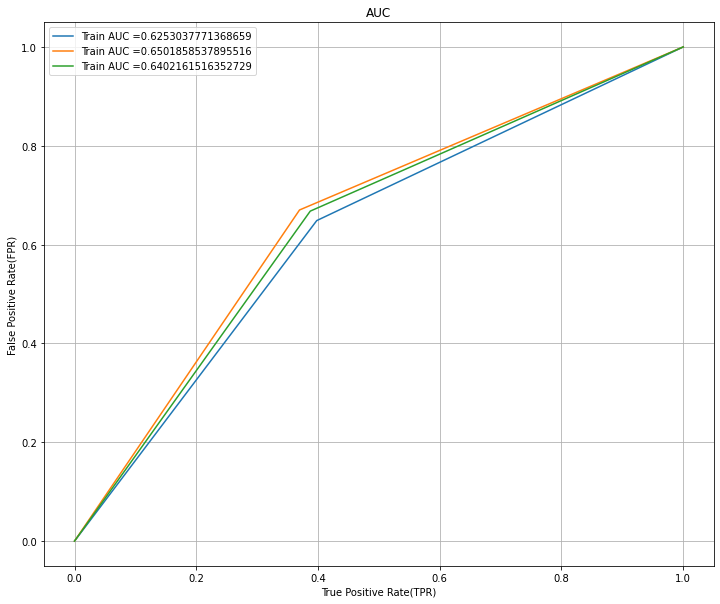

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification

#train_fpr, train_tpr, tr_thresholds = metrics.roc_curve(df1_y, preds1)
train_fpr0, train_tpr0, tr_thresholds0 = metrics.roc_curve(ytrain_predicts[0], df1_y)
train_fpr1, train_tpr1, tr_thresholds1 = metrics.roc_curve(ytrain_predicts[1], df1_y)
train_fpr2, train_tpr2, tr_thresholds2 = metrics.roc_curve(ytrain_predicts[2], df1_y)
roc_auc = metrics.auc(train_fpr, train_tpr)

plt.figure(figsize=(12,10))

plt.plot(train_fpr0, train_tpr0, label="Train AUC ="+str(auc(train_fpr0, train_tpr0)))
plt.plot(train_fpr1, train_tpr1, label="Train AUC ="+str(auc(train_fpr1, train_tpr1)))
plt.plot(train_fpr2, train_tpr2, label="Train AUC ="+str(auc(train_fpr2, train_tpr2)))


plt.legend()
plt.xlabel("True Positive Rate(TPR)")
plt.ylabel("False Positive Rate(FPR)")
plt.title("AUC")
plt.grid()
plt.show()

In [ ]:
def predict(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    #print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
# train AUC is more for k =400
print("Train confusion matrix")
cm = confusion_matrix(df1_y, predict(ytrain_predicts[1], tr_thresholds1, train_fpr1, train_tpr1))
print(cm)

Precision = cm[0][0]/(cm[0][0]+cm[0][1])
Recall = cm[0][0]/(cm[0][0]+cm[1][0])
f1_score = 2*(Precision*Recall)/(Precision+Recall)

print("="*100)
print("F1 Score",f1_score)
print("Precision",Precision)
print("Recall",Recall) 

Train confusion matrix
[[1030  985]
 [ 604 2000]]
F1 Score 0.5645382296519595
Precision 0.511166253101737
Recall 0.6303549571603427
